In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from pandas.tools.plotting import lag_plot
from pandas.tools.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller


from statsmodels.tsa.arima_model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
import pystan

In [3]:
def month_string_to_number(string):
    """ month_string_to_number takes a month and turns it into the 
    corresponding number
    args:
        :string - each item is a string

    returns:
        :(out) - the equivalent of the month's number
    """
    m = {
        'jan': 1,
        'feb': 2,
        'mar': 3,
        'apr':4,
         'may':5,
         'jun':6,
         'jul':7,
         'aug':8,
         'sep':9,
         'oct':10,
         'nov':11,
         'dec':12
        }
    s = string.strip()[:3].lower()

    try:
        out = m[s]
        return out
    except:
        raise ValueError('Not a month')
        
path = '/Users/afugere/Desktop/UVM Masters/GraduateSemester2/STAT330/FinalProject/'
path2 = '/Users/abigailhotaling/Documents/STAT_330_Project/Data/'
data = pd.read_csv(path2+ 'Electricity_Residential_Price_New_England.csv')

#data.columns = ['Date', 'Electricity Residential Price: New England cents per kilowatthour']
data.columns = ['Date', 'Electricity Price']
# I also changed the column name for now, just to be a little bit shorter 
dates = []
months = []
years = []
for entry in data['Date']:
    dates.append(entry.replace('-', ' '))
    data['Month and Year'] = pd.Series(dates)
    months.append(month_string_to_number(str(entry[0:-3])))
    years.append(entry[-2:])
    data['Month'] = pd.Series(months)
    data['Year'] = pd.Series(years)
    
updated_years = []
for y in data['Year']:
    if int(y) > 19:
        updated_years.append('19'+y)
    else:
        updated_years.append('20'+y)
    data['Year'] = pd.Series(updated_years)
    
data['Day'] = [1]*len(data)

data['Datetime'] = pd.to_datetime(data[['Year', 'Month', 'Day']])
data.iloc[:] = data.iloc[::-1].values

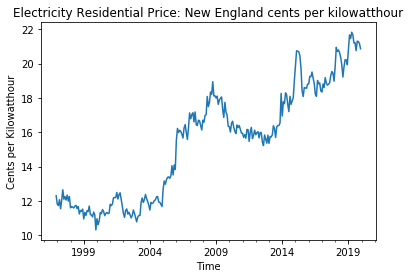

In [4]:
ax = data.plot(x = 'Datetime', y = 'Electricity Price', 
               title = 'Electricity Residential Price: New England cents per kilowatthour', legend = False)
ax.set_xlabel('Time')
ax.set_ylabel('Cents per Kilowatthour')
ax.format_xdata = mdates.DateFormatter('%Y-%m')

Model 1:

AR(2)

p=2 (number of lags)

$y_t = \alpha + \phi_1 y_{t-1} + \phi_2 y_{t-2}+\epsilon_t$

$\epsilon_t \sim N(0, \sigma^2)$

Need to estimate posterior for $\sigma^2$, $\phi_i$, $\alpha$ for $i=1, ...,2$ 

Priors: 

$\alpha \sim N(0, 1)$

$\phi_i \sim N(0, 1)$ for i in $i=1, ...,p$

$\sigma^2 \sim \Gamma^{-1}(a, b)$

Arbitrarily choose $a$ and $b$

Higher values of $b$ would give a wider distribution. And $a=b=1$ is an uniformitive prior. 

In [62]:
m1_stan_code = """
data {

    int T; // number of time steps
    int K; // Number of time series
    int P; // Number of lags for AR element
    
    matrix[T, K] Y; // data to model
        
    // priors
    real alpha_prior_location;
    real alpha_prior_scale;
    
    real sigma_prior_location;
    real sigma_prior_scale;
    
    real phi_prior_location;
    real phi_prior_scale;
    
}

transformed data{
    matrix[T,P] Y_lagged[K];
        
    for (k in 1:K){
        Y_lagged[k] = rep_matrix(0,T,P);
        for (p in 1:P){
            Y_lagged[k, p+1:T,p] = Y[1:T-p,k];
        }
    } 
}

parameters {
    vector[K] alpha; //intercept
    vector<lower=0>[K] sigma;
    matrix[K,P] phi; //lag parameters
}


model {
    matrix[T,K] err;
    matrix[T,K] nu;
    
    alpha ~ normal(alpha_prior_location, alpha_prior_scale);
    //sigma ~ cauchy(sigma_prior_location, sigma_prior_scale);
    sigma ~ inv_gamma(sigma_prior_location, sigma_prior_scale);
    if (P>0){
    for (p in 1:P){
        phi[:,p] ~ normal(phi_prior_location, phi_prior_scale);
    }
    }
    
    
    for (k in 1:K) {
        nu[:,k] = rep_vector(alpha[k], T);
        if (P>0){
            nu[:,k] = nu[:,k] + Y_lagged[k]*phi[k]';
        }
    }
    
    err = Y - nu;
    
    for (k in 1:K){
        err[P+1:T,k] ~ normal(0, sigma[k]);
    }
}"""

In [64]:
m1_data = {'T':len(data), 'K':1, 'P':2, 'Y':np.asarray(list(data['Electricity Price'])).reshape(len(data), 1),
           "alpha_prior_location": 0, 'alpha_prior_scale':1, 'sigma_prior_location': 1, 'sigma_prior_scale':1, 
           'phi_prior_location':0, 'phi_prior_scale':1}


In [65]:
fit = pystan.stan(model_code=m1_stan_code, data=m1_data, iter=1000, warmup = 100, chains=3)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_29faab67f95b545bed2e8a33d36fba9d NOW.


In [66]:
print(fit)

Inference for Stan model: anon_model_29faab67f95b545bed2e8a33d36fba9d.
3 chains, each with iter=1000; warmup=100; thin=1; 
post-warmup draws per chain=900, total post-warmup draws=2700.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha[1]    0.1  4.6e-3   0.13  -0.14   0.02    0.1   0.19   0.35    781    1.0
sigma[1]   0.43  3.9e-4   0.02    0.4   0.42   0.43   0.44   0.47   2362    1.0
phi[1,1]   0.85  1.8e-3   0.06   0.74   0.81   0.85   0.89   0.96   1071    1.0
phi[1,2]   0.15  1.8e-3   0.06   0.04   0.11   0.15   0.19   0.26   1073    1.0
lp__      92.36    0.05   1.45  88.75  91.65  92.69  93.43  94.12   1016    1.0

Samples were drawn using NUTS at Fri Nov 16 14:50:16 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


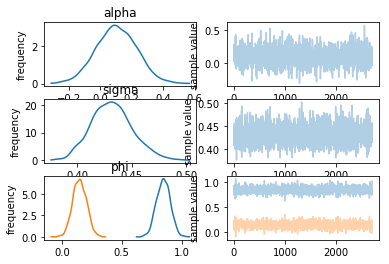

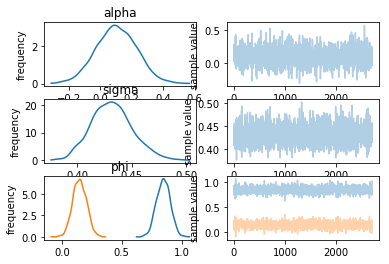

In [67]:
fit.plot()


We seem to have convergence 

[Abby to-do]

    Need to look at these results compared to frequentist methods

    Look at residuals and model diagnostics
    
